In [1]:
import os
import pandas as pd
import numpy as np
from IPython.display import display
from src.load_df import *
from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
filelist = make_filelist(data_path='../국립암센터_데이터')
make_list = lambda x:make_filelist(data_path=f'../국립암센터_데이터/{x}/')

In [939]:
read_df = lambda x:read_table(f'../국립암센터_데이터/{x.split("_")[0]}/{x}')

df = read_df('BRST_PT_BSNF.csv')
df_dead = read_df('BRST_DEAD_NFRM.csv')
df_image = read_df('BRST_EX_IMAG.csv')
df_diag = read_df('BRST_EX_DIAG.csv')

Skipping line 247334: unexpected end of data
Skipping line 902421: unexpected end of data


In [ ]:
from IPython.display import display
display(df.head())
display(df_image.head())
display(df_diag.head())

In [13]:
df['PT_SBST_NO'].nunique(), df_image['PT_SBST_NO'].nunique(), df_diag['PT_SBST_NO'].nunique()

(13815, 7645, 1984)

In [15]:
print('demographic과 진단서의 교집합')
print(len(np.intersect1d(df['PT_SBST_NO'], df_image['PT_SBST_NO'])))

print('demographic과 진단검사수치의 교집합')
print(len(np.intersect1d(df['PT_SBST_NO'], df_diag['PT_SBST_NO'])))

print('진단검사수치와 진단서의 교집합')
print(len(np.intersect1d(df_diag['PT_SBST_NO'], df_image['PT_SBST_NO'])))

print('전체 교집합')
print(len(np.intersect1d(df['PT_SBST_NO'],np.intersect1d(df_diag['PT_SBST_NO'], df_image['PT_SBST_NO']))))


demographic과 진단서의 교집합
7645
demographic과 진단검사수치의 교집합
1984
진단검사수치와 진단서의 교집합
1947
전체 교집합
1947


# Pivot <- 진단검사

In [941]:
# 이중 검사명에 #이 들어간 것은 포함하지 않음
df_diag['CEXM_NM'].unique()

실제 검사명은 생략


In [104]:
# 검사 단위가 %대신 #인 것들은 생략
df_diag = df_diag[df_diag['CEXM_NM'].str.contains('#')==False]

In [942]:
# 검사단위가 두개 이상이면 다수인 쪽을 따르기로
# 200개 미만인 검사명들은 버리기로 함

grouped_unit = df_diag.groupby('CEXM_NM')['CEXM_KIND_REF_VL_UNIT_CONT'].apply(pd.value_counts)
grouped_unit.head()

CEXM_NM               
AFP[Serum]       ng/mL      102
                 IU/mL       44
ALT(GPT)[Serum]  IU/L     26922
AST(GOT)[Serum]  IU/L     26890
Albumin[Serum]   g/dL     26416
Name: CEXM_KIND_REF_VL_UNIT_CONT, dtype: int64

In [ ]:
cond = grouped_unit>=500
using_diagnosis = grouped_unit[cond]

In [124]:
# 사용할 변수만 취합
using_diagnosis = np.array(using_diagnosis.index.tolist())[:,0]
df_diag_simple = df_diag[df_diag['CEXM_NM'].isin(using_diagnosis)]
# 검사수치가 빈 것들은 날림
df_diag_simple = df_diag_simple.dropna(subset = ['CEXM_RSLT_CONT'])
# 같은 환자가 같은 날짜에 같은 검사명을 받은 경우 하나만 남김(검사수치가 거의 비슷한 값으로 입력되어 있음)
df_diag_simple = df_diag_simple.drop_duplicates(subset = ['PT_SBST_NO','CEXM_YMD','CEXM_NM'])

In [141]:
df_diag_pivot = df_diag_simple.pivot(index=['PT_SBST_NO','CEXM_YMD'],columns='CEXM_NM',values='CEXM_RSLT_CONT')
df_diag_pivot = df_diag_pivot.reset_index()

# 의미없는 정보는 버림

In [158]:
cond_demo = df['PT_SBST_NO'].isin(df_diag_pivot['PT_SBST_NO'])
cond_img = df_image['PT_SBST_NO'].isin(df_diag_pivot['PT_SBST_NO'])

df_essential = df[cond_demo]
df_img_essential = df_image[cond_img]

In [159]:
del df
del df_image

In [160]:
df_essential.columns

Index(['CENTER_CD', 'IRB_APRV_NO', 'PT_SBST_NO', 'FRMD_YMD',
       'BRST_CNCT_LAST_MTRT_YMD', 'CENTER_LAST_VST_YMD', 'BRYM', 'IDGN_AGE',
       'INOP_AGE', 'PT_SEX_CD', 'PT_SEX_CD_ETC_CONT', 'CRTN_DT'],
      dtype='object')

In [161]:
df_essential = df_essential.drop(['CENTER_CD', 'IRB_APRV_NO','PT_SEX_CD_ETC_CONT', 'CRTN_DT'],axis=1)

In [163]:
df_img_essential = df_img_essential.drop(['CENTER_CD', 'IRB_APRV_NO','CRTN_DT','IMEX_RSLT_CONT'],axis=1)

In [164]:
df_essential.shape, df_diag_pivot.shape, df_img_essential.shape

((1984, 8), (38072, 35), (64663, 10))

# merge

기본환자정보 + 진단검사수치 + 진단서가 있는 환자를 대상으로 진행

df_image : IMEX_YMD(영상검사일자)<br>
df_diag : CEXM_YMD(진단검사일자)

In [943]:
df_img_essential.shape, df_diag_pivot.shape

((64663, 10), (38072, 35))

다음과 같이 하면 중복 데이터가 많이 생김
- df_merged = pd.merge(df_diag_pivot, df_img_essential, how='right', on='PT_SBST_NO')
- 날짜까지 고려하여 병합하되 일치하지 않을 수 있으므로 가장 최근접의 날짜로 병합

기준 : PT_SBST_NO, df_diag_essential의 날짜 + 가장 직후의 image 소견서
- ex) df_image : 20180520, 20180526, df_diag : 20180515, 20180524
- diag0515 <-> image0520, diag0524 <-> image0526

구간화 기준 : df_diag, 단 같은 환자대체번호에 대하여

In [357]:
def get_merge(PT_SBST_NO):
    df_img_temp = df_img_essential.query(f'PT_SBST_NO=={PT_SBST_NO}')
    df_diag_temp = df_diag_pivot.query(f'PT_SBST_NO=={PT_SBST_NO}')
    standard = df_img_temp['IMEX_YMD'].unique().tolist()
    if max(standard) < df_diag_temp['CEXM_YMD'].max():
        standard += [df_diag_temp['CEXM_YMD'].max()]
    if min(standard) >= df_diag_temp['CEXM_YMD'].min():
        standard += [df_diag_temp['CEXM_YMD'].min()-1]
    df_diag_temp['IMEX_YMD'] = pd.cut(df_diag_temp['CEXM_YMD'], bins=np.unique(standard)).astype(str).replace('.0','').str.split(',').str[1].str[:-1].astype(int)
    merged = pd.merge(df_diag_temp, df_img_temp, how='left',on=['PT_SBST_NO','IMEX_YMD']).drop_duplicates(subset = ['PT_SBST_NO','CEXM_YMD'], keep='last')
    return merged

In [944]:
df_img_diag = pd.DataFrame()
for i,pt_sbst_no in enumerate(df_img_essential['PT_SBST_NO'].unique()):
    if i%500==0:
        print(i)
    merged = get_merge(pt_sbst_no)
    df_img_diag = pd.concat([df_img_diag,merged])

0
500
1000
1500


In [365]:
df_result = pd.merge(df_essential,df_img_diag, how='right', on='PT_SBST_NO')
df_result.shape

(37963, 51)

# 사망

In [368]:
dead = read_df('BRST_DEAD_NFRM.csv')

In [374]:
df_result_dead = pd.merge(df_result,dead[['PT_SBST_NO','DEATH_YMD']] ,how='left')

In [375]:
df_result_dead['DEATH_YMD'].isnull().sum()

32703

In [376]:
df_result_dead.shape

(37963, 52)

In [378]:
df_result_dead.drop_duplicates(subset=['PT_SBST_NO'])[['PT_SBST_NO','DEATH_YMD']].isnull().sum()

PT_SBST_NO       0
DEATH_YMD     1826
dtype: int64

In [380]:
temp = df_result_dead.drop_duplicates(subset=['PT_SBST_NO'])[['PT_SBST_NO','FRMD_YMD','DEATH_YMD']]
dead_period = (pd.to_datetime(temp['DEATH_YMD'],format='%Y%m%d') - pd.to_datetime(temp['FRMD_YMD'],format='%Y%m%d')).dropna().astype(str).str.split(' ').str[0].astype(int)

In [392]:
dead_period.describe()

count     121.000000
mean      865.677686
std       720.461429
min         3.000000
25%       364.000000
50%       673.000000
75%      1128.000000
max      3596.000000
dtype: float64

In [398]:
df_result_dead.groupby('PT_SBST_NO').count()['FRMD_YMD'].describe()

count    1947.000000
mean       19.498202
std        19.430493
min         1.000000
25%         7.000000
50%        14.000000
75%        25.500000
max       244.000000
Name: FRMD_YMD, dtype: float64

In [410]:
df_result_dead.shape

(37963, 52)

# 논의
1. 진단검사 : 보간
2. 환자당 데이터를 하나만 남길지 or 환자/날짜별로 여러개를 남길지

In [429]:
diag = df_result_dead.iloc[:,[0]+list(range(8,43))]

In [499]:
asnan = lambda x:np.nan if x=='' else x
def interpolation(df):
    df['CEXM_YMD'] = pd.to_datetime(df['CEXM_YMD'], format='%Y%m%d')
    def interpolation_col(df,col):
        se = df.set_index('CEXM_YMD')[col].astype(str).str.replace('<','').str.replace('>','').str.replace('-','').map(asnan).astype(float).interpolate(method='time').round(1)
        return se.values
    for col in np.setxor1d(df.columns,['PT_SBST_NO','CEXM_YMD']):
        df[col] = interpolation_col(df,col)
    return df

'<100' -> 100
'-' -> np.nan
'>50' -> 50

In [500]:
# interpolation(diag.query('PT_SBST_NO==1024060'))

diag_interpol = diag.groupby('PT_SBST_NO').apply(interpolation)

In [945]:
temp = diag_interpol.notnull().sum()/diag_interpol.shape[0]
# 검사명에 해당하는 index는 생략
# null값 비율만을 출력
print(temp[temp>0.7].values)

[1.         1.         0.99299318 0.99299318 0.99286147 0.99212391
 0.99309854 0.97294734 0.97207808 0.99259806 0.98643416 0.99301952
 0.83639333 0.84042357 0.99294049 0.99720781 0.99710244 0.99251903
 0.99633854 0.99715512 0.99715512 0.99718147 0.99633854 0.99720781
 0.99720781 0.99238732 0.99291415 0.99220293 0.99712878 1.        ]


In [530]:
df_result_dead.iloc[:,[0]+list(range(8,43))] = diag_interpol
df_result_dead = df_result_dead.drop(temp[temp<0.7].index.tolist(),axis=1)
drop_list = ['BRYM','INOP_AGE','IMEX_CD','IMEX_SEQ','IMEX_KIND_NM','IMEX_EDI_CD','IMEX_NM']
df_result_dead = df_result_dead.drop(drop_list, axis=1)
df_result_dead.shape

(37963, 39)

In [532]:
df_result_dead.to_csv('중간결과.csv',index=False)

In [ ]:
# 지켜볼 변수
temp_list = ['FRMD_YMD','BRST_CNCT_LAST_MTRT_YMD','CENTER_LAST_VST_YMD','CEXM_YMD','IMEX_YMD']

# translated 이후

In [559]:
se = pd.read_csv('translate.csv')
df = pd.read_csv('중간결과.csv')

In [561]:
se.shape, df.shape

((37963, 2), (37963, 39))

In [564]:
temp_df = pd.DataFrame()
temp_df['원문'] = df['IMEX_OPN_CONT']
temp_df['번역'] = se.iloc[:,1]

In [573]:
temp_df.iloc[:,1].str.contains('src=ko').values.nonzero()

(array([    2,     3,     4, ..., 37958, 37960, 37961]),)

In [587]:
def get_str(x):
    x = x.split('text=')[1]
    x = x.split(', pronunciation')[0]
    return x

In [597]:
# 2971, 13252
temp_df[temp_df['번역'].isnull()]

,원문,번역
2971,Tc-99m HDP was given intravenously to the pati...,NaN
13252,\r\nTc-99m HDP was given intravenously to the ...,NaN


In [599]:
temp_df = temp_df.dropna(subset=['번역'])
temp_df['번역'] = temp_df['번역'].map(get_str)

In [601]:
temp_df.head()

,원문,번역
0,\r\nTechnique:\r\nTc-99m HDP was given to the ...,Technique:\r\nTc-99m HDP was given to the pati...
1,\r\nTechnique: \r\nTc-99m RBC was given to the...,Technique: \r\nTc-99m RBC was given to the pat...
2,(Diagnostic MRI) \r\n \r\nNeoadjuvant chem...,(Diagnostic MRI)\r\n \r\nNeoadjuvant chemoth...
3,(Diagnostic MRI) \r\n \r\nNeoadjuvant chem...,(Diagnostic MRI)\r\n \r\nNeoadjuvant chemoth...
4,(Diagnostic MRI) \r\n \r\nNeoadjuvant chem...,(Diagnostic MRI)\r\n \r\nNeoadjuvant chemoth...


In [603]:
new_df = pd.concat([df.drop('IMEX_OPN_CONT',axis=1), temp_df['번역']], axis=1)

In [608]:
new_df.shape

(37963, 39)

In [609]:
new_df = new_df.drop([2971, 13252])

In [610]:
new_df.shape

(37961, 39)

In [611]:
new_df.to_csv('translated_df.csv',index=False)

In [929]:
print(new_df['번역'][0].replace('.','\n'))

Technique:
Tc-99m HDP was given to the patient intravenously
 Anterior and posterior whole body and spot views were obtained 3 hours later
 

Findings and impression:
No significant bone uptake to suggest skeletal metastasis is noted in this study



# 시간에 따른 보간

- embedding은 이미 수행
- 한개만 사용 : 첫행, 마지막 행
- 여러개 사용 : CEXM_YMD에 따른 선형 보간 후 normalize-> 가중치로 삼아 진단검사수치 및 bert embedding을 가중합한 변수로 바꿈

In [651]:
new_df = new_df.reset_index(drop=True)

In [652]:
df_drop = new_df.drop(['FRMD_YMD','BRST_CNCT_LAST_MTRT_YMD','CENTER_LAST_VST_YMD','IMEX_YMD','IMEX_IN_YN','BRCN_IMEX_KIND_CD'],axis=1)

In [653]:
embedding = pd.read_csv('embedding_biobert.csv')

In [722]:
df_embedding = pd.concat([df_drop,embedding],axis=1)
df_embedding = df_embedding.sort_values(by = ['PT_SBST_NO','CEXM_YMD'])

In [736]:
df_all = df_embedding.drop(['번역'], axis=1)
df_all['PT_SEX_CD'] = df_all['PT_SEX_CD'].map({'F':1,'M':0})

In [737]:
# 첫째행 데이터
df_first = df_all.groupby('PT_SBST_NO').head(1)

In [738]:
# 마지막행 데이터
df_last = df_all.groupby('PT_SBST_NO').tail(1)

In [746]:
cols = ['ALT(GPT)[Serum]','Albumin[Serum]','BUN[Serum]']
temp = df_embedding[['PT_SBST_NO','CEXM_YMD','DEATH_YMD']+cols].query('PT_SBST_NO ==134754 ')
temp

,PT_SBST_NO,CEXM_YMD,DEATH_YMD,ALT(GPT)[Serum],Albumin[Serum],BUN[Serum]
240,134754,2019-03-04,NaN,14.0,5.1,7.8
241,134754,2019-03-26,NaN,14.0,4.9,6.8
242,134754,2019-04-17,NaN,14.0,4.7,5.7
243,134754,2019-05-08,NaN,14.0,4.5,4.7
244,134754,2019-05-29,NaN,14.5,4.7,6.7
245,134754,2019-06-21,NaN,15.0,5.0,8.8
246,134754,2019-07-12,NaN,15.5,5.0,8.9
247,134754,2019-08-02,NaN,16.0,5.0,9.0
248,134754,2019-08-23,NaN,17.9,5.0,9.1
249,134754,2019-09-16,NaN,20.0,5.1,9.2


In [858]:
def weight_mean_by_time(df, except_cols, standard = 'CEXM_YMD'):
    time_weight = (pd.to_datetime(df['CEXM_YMD']) - pd.to_datetime(df['CEXM_YMD'].min())).dt.days + 1
    transformed = []
    for col in df.columns:
        if col in except_cols:
            y = df[col].iloc[0]
        else:
            cond = df[col].notnull()
            if cond.sum()==0:
                y = np.nan
            else:
                y = np.average(df.loc[cond, col], weights = time_weight[cond])
        transformed.append(y)
    return pd.Series(transformed, index=df.columns)

In [844]:
weight_mean_by_time(temp, except_cols = ['PT_SBST_NO','CEXM_YMD','DEATH_YMD'])

PT_SBST_NO             134754
CEXM_YMD           2019-03-04
DEATH_YMD                 NaN
ALT(GPT)[Serum]       13.7362
Albumin[Serum]        4.20572
BUN[Serum]             7.9235
dtype: object

In [842]:
except_cols = ['IDGN_AGE','PT_SEX_CD','CEXM_YMD','DEATH_YMD']
weight_mean_by_time_cond = lambda x:weight_mean_by_time(x, except_cols=except_cols)

In [859]:
df_aggregated = df_all.groupby('PT_SBST_NO').apply(weight_mean_by_time_cond)

In [862]:
df_aggregated.to_csv('df_agg.csv',index=False)

In [766]:
df_first.to_csv('df_first.csv',index=False)
df_last.to_csv('df_last.csv',index=False)

# 모델 결과

In [767]:
df = pd.read_csv('df_first.csv')
X = df.drop(['PT_SBST_NO','CEXM_YMD','DEATH_YMD'],axis=1)
y = df['DEATH_YMD']

In [863]:
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score as auc
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import precision_score as precision
from sklearn.metrics import recall_score as recall
from sklearn.metrics import f1_score as f1
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix


In [864]:
lr = LogisticRegression(class_weight="balanced")

displayings = []
files = ['df_first.csv','df_last.csv','df_agg.csv']
for file in files:
    df = pd.read_csv(file)
    X = df.drop(['PT_SBST_NO','CEXM_YMD','DEATH_YMD'],axis=1)
    y = df['DEATH_YMD']

    X_median = X.median()
    X = X.fillna(X_median)
    y = y.fillna(0).map(lambda x:1 if x!=0 else x)
    temp_displaying = []
    fig, axes = plt.subplots(1,3,figsize = (10,6))
    result_df = pd.DataFrame()
    for method, data,ax in zip(['without embedding','only embedding', 'with embedding'],[X.iloc[:,:29], X.iloc[:,29:], X], axes):

        y_pred_lr = cross_val_predict(lr, data, y, method = 'predict_proba')
        y_pred = y_pred_lr.argmax(axis=1)
        roc_score = auc(y,y_pred_lr[:,1])

        result_se = pd.Series({'data':file,'acc':acc(y,y_pred), 
                               'recall':recall(y,y_pred), 'precision':precision(y,y_pred), 'f1_score':f1(y,y_pred), 'roc_score':roc_score})
        result_df[method] = result_se
        fpr, tpr, _ = roc_curve(y,y_pred_lr[:,1])
        
        ax.plot(fpr, tpr, '-')
        ax.set_title(f'{method} : \n{np.round(roc_score,4)}', fontsize=15)
        ax.set_xlabel('fpr',fontsize=12)
        ax.set_ylabel('tpr',fontsize=12)
    plt.tight_layout()
    plt.close()
    temp_displaying.append(fig)
    temp_displaying.append(result_df)
    displayings.append(temp_displaying)

In [812]:
def display_horizon(*args,display_type = 1):
    widget_list = list()
    for obj in args:
        widget_temp = widgets.Output()
        with widget_temp:
            display.display(obj)
            widget_list.append(widget_temp)
    return widgets.HBox(widget_list)
    


In [813]:
from ipywidgets import widgets, Layout
from IPython import display

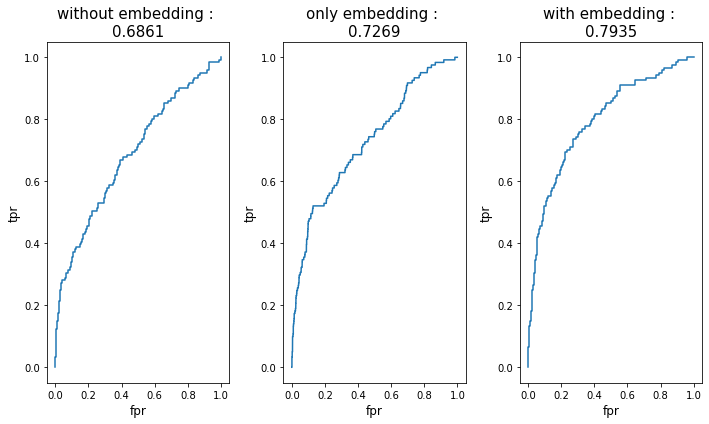

,without embedding,only embedding,with embedding
data,df_first.csv,df_first.csv,df_first.csv
acc,0.739599,0.873652,0.797124
recall,0.504132,0.438017,0.636364
precision,0.120079,0.229437,0.179907
f1_score,0.193959,0.301136,0.28051
roc_score,0.686113,0.726949,0.793456


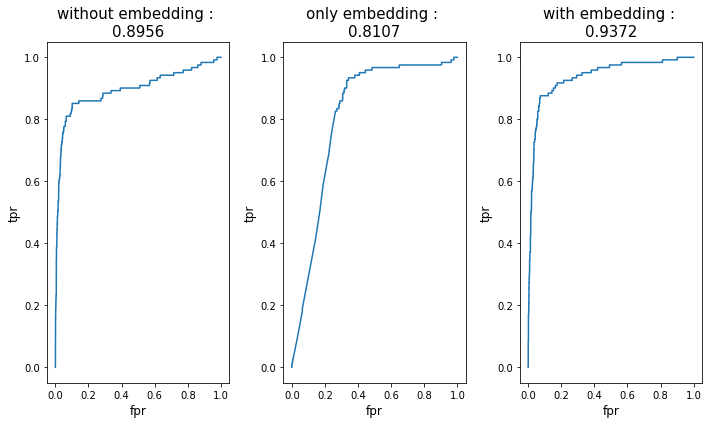

,without embedding,only embedding,with embedding
data,df_last.csv,df_last.csv,df_last.csv
acc,0.916281,0.734463,0.919363
recall,0.809917,0.826446,0.876033
precision,0.411765,0.167785,0.427419
f1_score,0.545961,0.27894,0.574526
roc_score,0.89564,0.810709,0.937157


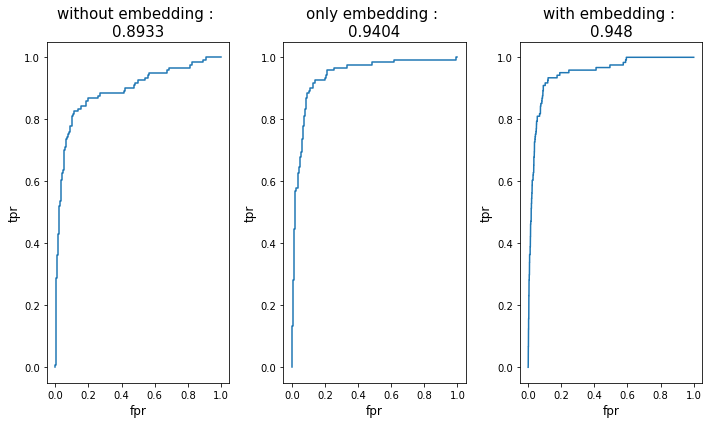

,without embedding,only embedding,with embedding
data,df_agg.csv,df_agg.csv,df_agg.csv
acc,0.896764,0.915254,0.914227
recall,0.77686,0.818182,0.85124
precision,0.350746,0.409091,0.40873
f1_score,0.48329,0.545455,0.552279
roc_score,0.893277,0.940424,0.947999


In [865]:
display_horizon(*displayings[0])
display_horizon(*displayings[1])
display_horizon(*displayings[2])


In [866]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.33, stratify = y)

In [867]:
lr.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [868]:
y_pred_proba = lr.predict_proba(X_test)

In [869]:
auc(y_test, y_pred_proba[:,1])

0.9487976782752903

In [870]:
lr = LogisticRegression(class_weight="balanced")
lr.fit(X,y)

LogisticRegression(class_weight='balanced')

In [879]:
coef = dict(zip(X.columns,lr.coef_[0]))
coef = pd.Series(coef).sort_values()

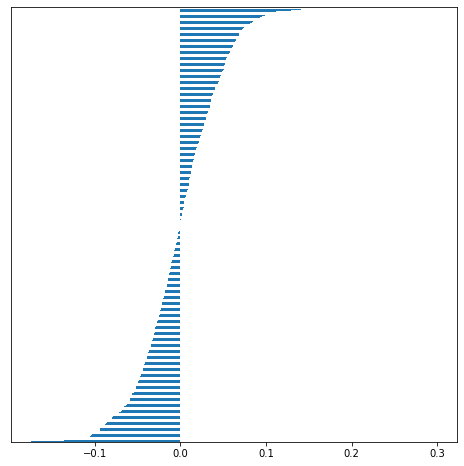

In [900]:
plt.figure(figsize=(8,8))
coef.plot(kind='barh')
plt.yticks([])
plt.show()

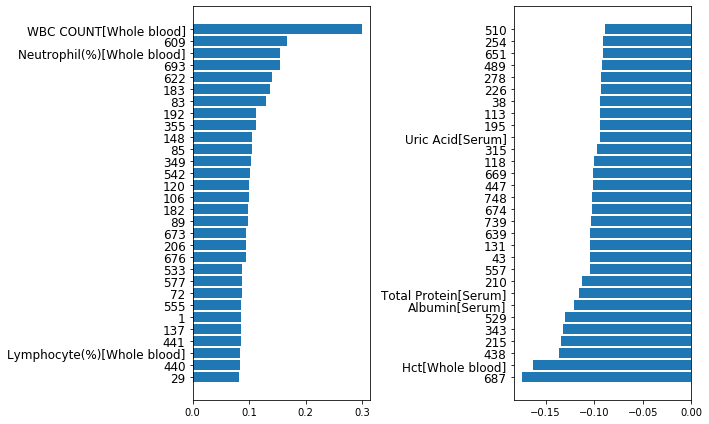

In [898]:
fig, ax = plt.subplots(1,2,figsize=(10,6))
ax[0].barh(range(30),coef.tail(30))
ax[0].set_yticks(range(len(coef.tail(30))))
ax[0].set_yticklabels(coef.tail(30).index, fontsize=12)

ax[1].barh(range(30),coef.head(30))
ax[1].set_yticks(range(len(coef.head(30))))
ax[1].set_yticklabels(coef.head(30).index, fontsize=12)
plt.tight_layout()
plt.show()